In [1]:
%matplotlib inline
import warnings
import dill
# dill.load_session('msm_whole_trajectories.db')
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import mdtraj as md
import matplotlib



In [2]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt


## Load and inspect the data

In [3]:
traj = md.load('data/traj_3.xtc',top= 'data/water_top.pdb')
dt = traj.timestep
traj = md.compute_center_of_mass(traj)
traj.shape

(10000001, 3)

In [4]:
# df = pd.DataFrame(com, columns=['1', '2', '3'])
# df['t'] = traj.time/1000

# df_melt = pd.melt(frame=df, id_vars=['t'], value_vars=['1', '2', '3'], var_name='coord', )

# df_melt.head()

In [5]:
# g = sns.FacetGrid(df_melt.iloc[::100,:], col='coord')
# g.map(plt.scatter, 't', 'value', alpha=0.5, s=1)
# g.set_axis_labels('time (ns)', 'position (nm)')

Text(0.5, 0, 'z')

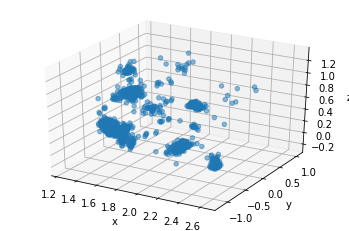

In [6]:
stride=5000
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
ax.scatter(xs=traj[::stride,0], ys=traj[::stride,1], zs=traj[::stride,2], alpha=0.5)
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.set_zlabel('z')

## Split data into 1ns pieces

This is because we have a wide variety of behaviour across the trajectory and we only want to focus on small chunks at a time. 

In [7]:
window = 1000 # window size in ps
n_frames = int(window/dt) # number of frames in a window
n_splits = traj.shape[0]//n_frames # number of windows in trajectory
traj_split = np.array_split(traj, n_splits) # the split up 

## Set MSM parameters


In [8]:
msm_lag = int(10/dt)
tica_lag = int(5/dt)
n_clusters = int(np.sqrt(n_frames))

## Fit models

In [9]:
# # Fit tica and get tica trajs
# tica_objs = [coor.tica(traj, lag=tica_lag, dim=3,  kinetic_map=True) for traj in traj_split]
# tica_trajs = [x.get_output() for x in tica_objs]

# Cluster using kmeans
dtraj_objs = [coor.cluster_kmeans(traj, k=n_clusters, max_iter=100) for traj in traj_split[:20]]


In [10]:
# Extract dtrajs
dtrajs = [x.dtrajs for x in dtraj_objs]

# get implied timescale plots
msms = [msm.estimate_markov_model(dtraj, lag=msm_lag) for dtraj in dtrajs]

Find the largest gap in the timescales first - some of these might give sink states though. 

In [11]:
ts_ratios = []
for mm in msms:
    ts = mm.timescales()[:5]
    ts_ratio = ts[:-1]/ts[1:]
    max_ratio = np.max(ts_ratio)
    n_states = np.argmax(ts_ratio)+2
    ts_ratios.append((mm, n_states, max_ratio))

Now fit the Hidden Markov Models. 

In [12]:
hmms = [(i, mm.coarse_grain(n)) for i, (mm, n, ratio) in enumerate(ts_ratios) if ratio > 1.5]


In [20]:
# If one of the lifetimes is infinity, that means there's an absorbing state so there's no oscilation
non_absorbing = [(i, hmm) for (i, hmm) in hmms if not np.any(np.abs(hmm.lifetimes)==np.inf)]

In [21]:
hmm_dict = dict(non_absorbing)


In [22]:
hmm_dict

{2: MaximumLikelihoodHMSM(accuracy=0.001, connectivity=None, dt_traj='1 step',
            lag=99, maxit=1000, mincount_connectivity=0.3333333333333333,
            msm_init=MaximumLikelihoodMSM(connectivity='largest', count_mode='sliding',
            dt_traj='1 step', lag=99, maxerr=1e-08, maxiter=1000000,
            mincount_connectivity='1/n', reversible=True, score_k=10,
            score_method='VAMP2', sparse=False, statdist_constraint=None),
            nstates=3, observe_nonempty=True, reversible=True,
            separate=None, stationary=False, stride=1),
 8: MaximumLikelihoodHMSM(accuracy=0.001, connectivity=None, dt_traj='1 step',
            lag=99, maxit=1000, mincount_connectivity=0.5,
            msm_init=MaximumLikelihoodMSM(connectivity='largest', count_mode='sliding',
            dt_traj='1 step', lag=99, maxerr=1e-08, maxiter=1000000,
            mincount_connectivity='1/n', reversible=True, score_k=10,
            score_method='VAMP2', sparse=False, statdist_cons

## Plot results

In [24]:
with sns.plotting_context('paper', font_scale=2.5):
    def axis_labs(ax):
        ax.set_xlim(1,3.); ax.set_ylim(-1, 1.); ax.set_zlim(-0.5, 1.5)
        ax.set_xlabel('x', labelpad=10); ax.set_ylabel('y', labelpad=10); ax.set_zlabel('z', labelpad=10)
        ax.xaxis.pane.fill=False; ax.yaxis.pane.fill=False; ax.zaxis.pane.fill=False
        ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=1))
        ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=1))
        ax.zaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=1))
        return ax
    
    for k, v in hmm_dict.items():
        # Get the relevant data
        idx = k

        hmm = v
        N = hmm.nstates
        obs_to_hid = np.argmax(hmm.metastable_memberships, axis=1)
        h_traj = [obs_to_hid[i] for i in hmm.discrete_trajectories_obs[0]]

        # Position data
        stride = 10
        big_stride = int(traj.shape[0]/10000)

        traj_idx = traj_split[idx]
        n_points = traj_idx[::stride,0].shape[0]

        # Set up figure and axes
        scale=1.5
        fig = plt.figure(figsize=(scale*12, scale*4))
        gs = fig.add_gridspec(1, 3,
                           width_ratios=[3,2,1])
        ax1 = fig.add_subplot(gs[0],projection='3d')
        ax2 = fig.add_subplot(gs[1])
        ax3 = fig.add_subplot(gs[2])

        fig.suptitle('{0} < time < {1} ns'.format(idx, idx+1) + r' | T($\tau={:4.0f}$ps)'.format(np.round(hmm.lag, -1)), 
                     horizontalalignment='center', verticalalignment='top')

        # Set up colors    
        cmap_use = 'viridis_r'
        cmap = matplotlib.cm.get_cmap(cmap_use,N)
        cols = [cmap(n) for n in range(N)]




        # cluster centers
        ax1.scatter(xs=traj_idx[::stride,0], ys=traj_idx[::stride,1], 
                    zs=traj_idx[::stride,2], alpha=1, c=h_traj[::stride], 
                   zorder=1, s=50, cmap=cmap) 

        # Whole trajectory
        ax1.scatter(xs=traj[::big_stride,0], ys=traj[::big_stride,1],
                   zs=traj[::big_stride,2], alpha=0.5,s=20, zorder=1, color='grey')
        ax1 = axis_labs(ax1)

        # Network
        r = 1
        x = np.array([r * np.cos(2*np.pi*n/N) for n in range(N)])
        y = np.array([r * np.sin(2*np.pi*n/N) for n in range(N)])
        pos = np.vstack((x,y)).T

        fig, pos = mplt.plot_markov_model(hmm, ax=ax2, arrow_curvature=1.5, state_colors=cols,
                                    arrow_label_format = '%2.2f', pos=pos,
                                    figpadding=0.3, arrow_scale=0.5)

        # Timescale plots
        mm = msms[idx]
        t_max = 10
        ts = mm.timescales()[:t_max]*dt

        # Slow:
        ax3.hlines(ts[0], 0, 1, lw=5, color='g', label='Slow')
        for i in range(1,N-1): 
            ax3.hlines(ts[i], 0, 1, lw=5, color='g')
        # Fast
        ax3.hlines(ts[N-1], 0, 1, lw=2, color='b', label='Fast')
        for i in range(N-1,t_max): ax3.hlines(ts[i], 0, 1, lw=2, color='b')

        ax3.set_ylabel('Timescales (ps)')
        ax3.set_yscale('log')
        locator = matplotlib.ticker.FixedLocator(locs=ts[:N])
        formatter = matplotlib.ticker.StrMethodFormatter('{x:4.0f} ps')
        ax3.yaxis.set_major_locator(locator)
        ax3.yaxis.set_major_formatter(formatter)
        ax3.tick_params(labelbottom = False, bottom=False)

        plt.tight_layout()
        plt.savefig('images/traj-3-section-{}'.format(idx))
        plt.close()